# Arbitrage Sandbox

Here we generate a set of internal markets (using `curvesim` and `crvusdsim`) and external markets (using `src.modules.market.py`). We also generate stochastic external market prices for all tokens pertaining to these markets.

Our goal is to derive an algorithm that identifies the optimal set of trades to maximize profits as the external market price of each token changes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

from src.modules.market import ExternalMarket
from src.modules.llamma import LLAMMA
from src.modules.oracle import Oracle
from src.sim.slippage import analyze

from curvesim.pool import get_sim_pool, SimCurvePool

from crvusdsim.pool import get as get_sim_llamma
from crvusdsim.pool import SimLLAMMAPool

In [3]:
WINDOW = 600  # 10 minutes
START = 1697675181  # Update with: datetime.now().timestamp()
TOKENS = ["USDT", "USDC", "USDP", "TUSD", "ETH", "BTC", "crvUSD"]

PRECISION_18 = 10**18
PRECISION_6 = 10**6

## Initialize pools

There are three kinds of pools:

1. StableSwap pools. These are Curve AMMs that we simulate using `curvesim`.
2. LLAMMAs. These are the AMMs that store collateral positions, like ETH/crvUSD. We are still deciding whether to simulate these using `crvusdsim`, a separate package for crvUSD (which is unstable and under development), or our own code in `src.modules`.
3. External markets. These are markets outside of Curve, and may be an AMM like Uniswap or a LOB like Binance. Since we have only analyzed the price impact on WETH/USDC on Uniswap, we will only create a single external market using the coefficients that we have observed. We can pretend that we have many external markets by feeding in different prices to the `trade` function.

In [4]:
# StableSwap Pools
USDC_POOL = "0x4DEcE678ceceb27446b35C672dC7d61F30bAD69E"  # USDC/crvUSD
USDT_POOL = "0x390f3595bca2df7d23783dfd126427cceb997bf4"  # USDT/crvUSD
USDP_POOL = "0xca978a0528116dda3cba9acd3e68bc6191ca53d0"  # USDP/crvUSD
TUSD_POOL = "0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0"  # TUSD/crvUSD

# Using curvesim
curve_pools: List[SimCurvePool] = [
    get_sim_pool(address, balanced=False)
    for address in [USDC_POOL, USDT_POOL, USDP_POOL, TUSD_POOL]
]

In [5]:
curve_pools[0].metadata

{'name': 'Curve.fi Factory Plain Pool: crvUSD/USDC',
 'address': '0x4DEcE678ceceb27446b35C672dC7d61F30bAD69E',
 'chain': 'mainnet',
 'symbol': 'crvUSDUSDC-f',
 'version': 1,
 'pool_type': 'CRVUSD',
 'params': {'A': 500,
  'fee': 1000000,
  'fee_mul': None,
  'admin_fee': 5000000000},
 'coins': {'names': ['USDC', 'crvUSD'],
  'addresses': ['0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
   '0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E'],
  'decimals': [6, 18]},
 'reserves': {'by_coin': [11244846741045000000000000,
   18899124298586245159704840],
  'unnormalized_by_coin': [11244846741045, 18899124298586245159704840],
  'virtual_price': 1004617407876018055},
 'basepool': None,
 'timestamp': 1699488000}

In [6]:
# LLAMMA Pools
ETH_POOL = "weth"  # wrapped version, prices are the same as ETH
BTC_POOL = "wbtc"  # wrapped version, prices are the same as BTC

# llammas = [get(name) for name in [ETH_POOL, BTC_POOL]]
sim_objects = get_sim_llamma(ETH_POOL, bands_data="controller")
llamma: SimLLAMMAPool = sim_objects[0]
llamma.metadata

{'llamma_params': {'name': 'Curve.fi Stablecoin WETH',
  'address': '0x1681195c176239ac5e72d9aebacf5b2492e0c4ee',
  'A': '100',
  'rate': '1391991215',
  'rate_mul': '1012482089875771940',
  'fee': '0.006',
  'admin_fee': '0.000000000000000001',
  'BASE_PRICE': '1915.190938738552257773',
  'active_band': '1',
  'min_band': '0',
  'max_band': '1043',
  'oracle_price': '1889.986667548102298307',
  'collateral_address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
  'collateral_precision': '18',
  'collateral_name': 'WETH',
  'collateral_symbol': 'WETH',
  'bands_x': defaultdict(int,
              {0: 446204335341394722816,
               1: 936981841146267041792,
               2: 0,
               3: 0,
               4: 0,
               5: 0,
               6: 0,
               7: 0,
               8: 0,
               9: 0,
               10: 0,
               11: 0,
               12: 0,
               13: 0,
               14: 0,
               15: 0,
               16: 0,
       

# Trading with `crvusdsim` and `curvesim`

Here's how you check the profit from a trade with `crvusdsim`. It's basically the same for `curvesim`, so I'm just showing the `curvesim` example here.

<b>A VERY IMPORTANT NOTE:</b> amounts in LLAMMA and regular Curve pools will always be scaled by 10^N where N is the decimals for that token. This is because the EVM does not handle floating point arithmetic, so everything is done with very large integers. Generally, most amounts will be scaled by 10^N, but some tokens are scaled by 10^6 instead (like USDC). The pool objects from `curvesim` and `crvusdsim` will always tell you how many decimals to use.

In [7]:
llamma.metadata[
    "coins"
]  # crvUSD is coin 0, WETH is coin 1 NOTE THESE INDEXES ARE IMPORTANT!

{'names': ['crvUSD', 'WETH'],
 'addresses': ['0xf939e0a03fb07f59a73314e73794be0e57ac1b4e',
  '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'],
 'decimals': [18, 18]}

In [8]:
# Notice the vast majority of the AMM is in ETH
# This is because LLAMMA primarily holds ETH collateral
# and only converts it to crvUSD if prices collapse.
# Since ETH/BTC have been on a bull run, the AMM is mostly ETH.
print(f"Total crvUSD in LLAMMA: {sum(llamma.bands_x.values()) / PRECISION_18:.2f}")
print(f"Total ETH in LLAMMA: {sum(llamma.bands_y.values()) / PRECISION_18:.2f}")

Total crvUSD in LLAMMA: 1383.19
Total ETH in LLAMMA: 9177.96


In [9]:
try_amt_in = 1_000_000 * PRECISION_18
coin_in = 0  # Selling crvUSD to the LLAMMA
coin_out = 1

print(f"Pre-Trade")
print(f"Total crvUSD in LLAMMA: {sum(llamma.bands_x.values()) / PRECISION_18:.2f}")
print(f"Total ETH in LLAMMA: {sum(llamma.bands_y.values()) / PRECISION_18:.2f}")
print(f"Price: {llamma.price(0, 1) / PRECISION_18:.2f}")

with llamma.use_snapshot_context():
    # The snapshot context allows us to check how much
    # a trade ~would~ cost without actually executing it
    amt_in, amt_out, fees = llamma.trade(coin_in, coin_out, try_amt_in)
    print(f"\nPost-Trade")
    print(f"Total crvUSD in LLAMMA: {sum(llamma.bands_x.values()) / PRECISION_18:.2f}")
    print(f"Total ETH in LLAMMA: {sum(llamma.bands_y.values()) / PRECISION_18:.2f}")
    print(f"Price post-trade: {llamma.price(0, 1) / PRECISION_18:.2f}\n")
    print(f"Amount sold: {amt_in / PRECISION_18:.2f} crvUSD")
    print(f"Amount bought: {amt_out / PRECISION_18:.2f} ETH")
    print(f"Fees paid: {fees / PRECISION_18:.2f} crvUSD")
    print(f"Execution Price: {amt_in / amt_out:.2f} ETH/crvUSD")


print(f"\nCheck that snapshot context works")
print(f"Total crvUSD in LLAMMA: {sum(llamma.bands_x.values()) / PRECISION_18:.2f}")
print(f"Total ETH in LLAMMA: {sum(llamma.bands_y.values()) / PRECISION_18:.2f}")
print(f"Price post-trade: {llamma.price(0, 1) / PRECISION_18:.2f}")

Pre-Trade
Total crvUSD in LLAMMA: 1383.19
Total ETH in LLAMMA: 9177.96
Price: 1852.17

Post-Trade
Total crvUSD in LLAMMA: 1001383.19
Total ETH in LLAMMA: 8721.22
Price post-trade: 2445.32

Amount sold: 1000000.00 crvUSD
Amount bought: 456.73 ETH
Fees paid: 6000.00 crvUSD
Execution Price: 2189.47 ETH/crvUSD

Check that snapshot context works
Total crvUSD in LLAMMA: 1383.19
Total ETH in LLAMMA: 9177.96
Price post-trade: 1852.17


# Now for the External Pools

External pools are not explicitly modeled, but we do our best to estimate the price impact of trades against them. We do this using a simple OLS regression analysis shown below.

Mean percentage error: 0.004%
Mean percentage error: 0.006%


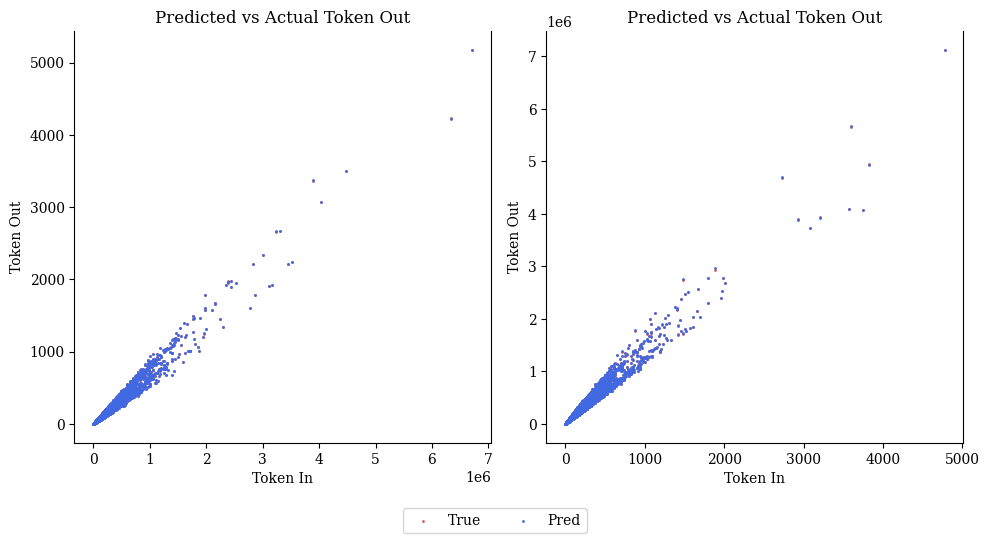

In [10]:
# External Pools
decimals = [18, 6]
coefs, intercepts, _ = analyze("../data/slippage/eth_usdc_0_3.csv", decimals, plot=True)
external_market = ExternalMarket(2, coefs, intercepts)

In [11]:
# Although we only created one external market, we can pretend that
# we have one external market for each permutation of tokens.
# For example
from itertools import combinations

list(combinations(TOKENS[:-1], 2))
# We can assume that all those external markets exist
# And we call external_market.trade(amt, price, i, j)
# based on the price if token i against token j

[('USDT', 'USDC'),
 ('USDT', 'USDP'),
 ('USDT', 'TUSD'),
 ('USDT', 'ETH'),
 ('USDT', 'BTC'),
 ('USDC', 'USDP'),
 ('USDC', 'TUSD'),
 ('USDC', 'ETH'),
 ('USDC', 'BTC'),
 ('USDP', 'TUSD'),
 ('USDP', 'ETH'),
 ('USDP', 'BTC'),
 ('TUSD', 'ETH'),
 ('TUSD', 'BTC'),
 ('ETH', 'BTC')]

### Executing a Trade against an External Market

Here's how we would execute a trade against an external market. Let's do ETH/USDC since that's what our existing coefs are trained on.

Notice that our External markets don't assume 10^18 precision.

In [12]:
amt_in = 1  # Let's trade one ETH
mkt_price = 1800  # Should be the ETH/USDC price from GBM
coin_in = 1  # ETH
coin_out = 0  # USDC

amt_out = external_market.trade(amt_in, mkt_price, coin_in, coin_out)
amt_out

1794.568373663363

In [13]:
# Notice we implicitly paid a fee. Given the amount traded was small
# we can assume price impact is negligible and reverse engineer the fee:
execution_price = amt_out / amt_in
print(f"Approximate fee paid: {1 - execution_price / mkt_price:.2%}")
# Since our training data was the WETH/USDC .3% pool on Uniswap, this is correct

Approximate fee paid: 0.30%


In [14]:
# Now let's see what happens with a large trade
amt_in = 1_000
mkt_price = 1800  # Should be the ETH/USDC price from GBM
coin_in = 1  # ETH
coin_out = 0  # USDC

amt_out = external_market.trade(amt_in, mkt_price, coin_in, coin_out)
amt_out

1787416.2137771898

In [15]:
# Notice we implicitly paid a fee. Given the amount traded was small
# we can assume price impact is negligible and reverse engineer the fee:
execution_price = amt_out / amt_in
print(f"Approximate fee and price impact: {1 - execution_price / mkt_price:.2%}")
# Notice we paid an extra 40bps in slippage/price impact

Approximate fee and price impact: 0.70%


# Generating Prices

Let's generate some simple prices using GBMs.

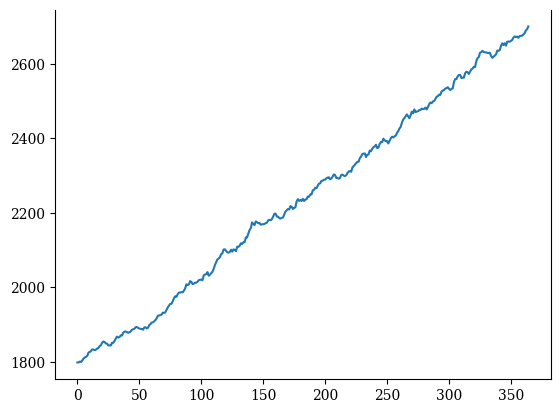

In [16]:
# We have a more sophisticated price generator and I'll sub it in here soon


def generate_gbm(S0, mu, sigma, T, dt):
    """
    Generate a Geometric Brownian Motion path.

    Parameters:
    S0 : float
        Initial stock price
    mu : float
        Expected return
    sigma : float
        Standard deviation of returns
    T : float
        Total time period
    dt : float
        Time step size

    Returns:
    numpy.ndarray
        Simulated GBM path
    """
    n = int(T / dt)
    t = np.linspace(0, T, n)
    W = np.random.standard_normal(size=n)
    W = np.cumsum(W) * np.sqrt(dt)  # the Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)  # the geometric brownian motion
    return S


prices = generate_gbm(1800, 0.001, 0.002, 365, 1)


plt.plot(prices)

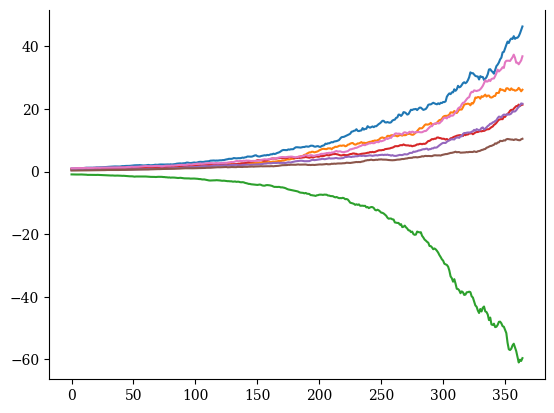

In [17]:
prices = []
for token in TOKENS:
    # Need to substitute this with realistic parameters
    s0 = np.random.randn(1)[0]
    mu = 0.01
    sigma = 0.02
    prices_i = generate_gbm(s0, mu, sigma, 365, 1)
    plt.plot(prices_i)
    prices.append(prices_i)

# To Do for Thomas

1. Create option for pull empirical prices.
2. Fix GBM generation for something reasonable.
3. Train price impact coefficients for other external markets.